# 2022 Bike Share Toronto Rides - Data Analysis

### OBJECTIVES:

1. Find the average elevation change per ride for Bike Share Toronto riders in 2022. (*Did riders show a tendency to take trips that are downhill?*)

2. Find the average elevation change per ride for Bike Share Toronto annual members vs. casual members in 2022. (*Did the average elevation change per ride differ for annual members vs. casual members?*)

3. Determine whether or not the ratio of a station's **number of rides ended / number of rides** negatively correlated with that station's elevation in 2022. (*Did stations at lower elevations tend to be a ride ending locations more often than ride starting locations?*)

### DATA SOURCES:
   * See data aggregation file: [data.ipynb](https://github.com/stephensavoia/stephensavoia.github.io/blob/main/bikeshare/data.ipynb)
   
### STEPS:

   * [1. Import Data](#1)
   * [2. Find Average Elevation Change](#2)
   * [3. Compare Annual Members to Casual Members](#3)
   * [4. Compare High Elevation Stations to Low Elevation Stations](#4)
   * [5. Next Steps](#5)

### 1. IMPORT DATA <a class="anchor" id="1"></a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import ride data
data = pd.read_csv('bike_share_data.csv')

# Change dtypes to save memory
for col in ['start_station_id', 'end_station_id']:
    data[col] = data[col].astype('int16')

data['trip_id'] = data['trip_id'].astype('int32')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230582 entries, 0 to 4230581
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   trip_id           int32  
 1   start_station_id  int16  
 2   end_station_id    int16  
 3   annual_member     bool   
 4   start_lat         float64
 5   start_lon         float64
 6   end_lat           float64
 7   end_lon           float64
 8   start_elevation   float64
 9   end_elevation     float64
dtypes: bool(1), float64(6), int16(2), int32(1)
memory usage: 230.0 MB


### 2. FIND AVERAGE ELEVATION CHANGE <a class="anchor" id="2"></a>

In [3]:
# Add new column, "elevation_change"
data['elevation_change'] = data['end_elevation'] - data['start_elevation']

# Find the average elevation change for all 2022 rides
print("The average elevation change per Bike Share Toronto ride in 2022 was " +
str(data['elevation_change'].mean().round(4)) +
" meters.")

The average elevation change per Bike Share Toronto ride in 2022 was -1.2983 meters.


<Axes: xlabel='elevation_change', ylabel='Count'>

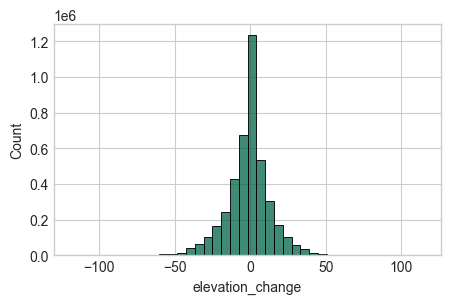

In [4]:
# Set colours, for future use in all graphs (colour palette taken from Bike Share Toronto website)
c_1_hex = "#006448"
c_2_hex = "#ea7023"
c_3_hex = "#01ae42"
c_1_dec_alpha8 = (0,0.4,0.28,0.8)
c_1_dec_alpha2 = (0,0.4,0.28,0.2)
sns.set_palette(sns.color_palette(["#006448","#ea7023","#01ae42"]))

# View the distribution of elevation change data as a histogram
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(5,3))
sns.histplot(data=data, x='elevation_change', bins=40)

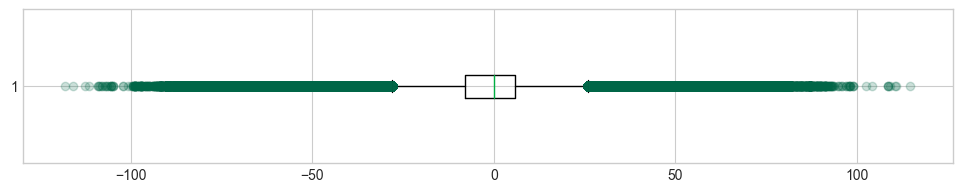

In [5]:
# View the distribution of elevation change data as a boxplot
plt.figure(figsize=(12,2))
plt.boxplot(data['elevation_change'], vert=False,
            flierprops={'markerfacecolor': c_1_dec_alpha2,
                        'markeredgecolor': c_1_dec_alpha2},
                        medianprops={'color':c_3_hex})
plt.show()

### 3. COMPARE ANNUAL MEMBERS TO CASUAL MEMBERS <a class="anchor" id="3"></a>

In [6]:
# Find the average elevation change for all 2022 rides by annual members
annual_members = data.loc[(data['annual_member'] == True), 'elevation_change']
annual_mean = annual_members.mean().round(4)

print("The average elevation change per annual member ride in 2022 was " +
str(annual_mean) + " meters.")

The average elevation change per annual member ride in 2022 was -1.5303 meters.


In [7]:
# Find the average elevation change for all 2022 rides by casual members
casual_members = data.loc[~(data['annual_member'] == True), 'elevation_change']
casual_mean = casual_members.mean().round(4)

print("The average elevation change per casual member ride in 2022 was " +
str(casual_mean) + " meters.")

The average elevation change per casual member ride in 2022 was -1.1607 meters.


In [8]:
# Find the difference in average elevation change per ride between annual members and casual members

print("In 2022, the average elevation loss for an annual member ride was " +
str((annual_mean - casual_mean).round(4) * -1) + " meters greater than that of a casual member ride.")

In 2022, the average elevation loss for an annual member ride was 0.3696 meters greater than that of a casual member ride.


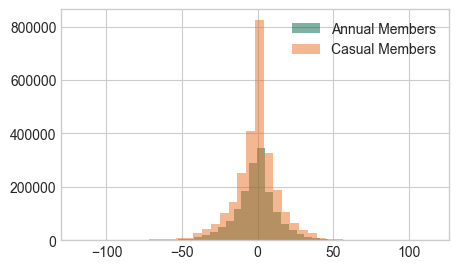

In [9]:
# Compare annual members to casual members visually, with a double histogram
plt.figure(figsize=(5,3))
plt.hist(annual_members, bins=40, alpha=0.5, label='Annual Members')
plt.hist(casual_members, bins=40, alpha=0.5, label='Casual Members')
plt.legend(loc='upper right')
plt.show()

### 4. COMPARE HIGH ELEVATION STATIONS TO LOW ELEVATION STATIONS <a class="anchor" id="4"></a>

In [10]:
# Aggregate data by start_station_id, to get the number of times each station was used to start a ride
# (keep station elevation data, also)
ride_start_data = data.groupby('start_station_id').agg({'trip_id':'count', 'start_elevation':'mean'}).reset_index()
ride_start_data = ride_start_data.rename(columns={
    'start_station_id' : 'station_id',
    'trip_id' : 'start_count',
    'start_elevation' : 'elevation'
})

# Aggregate data by end_station_id, to get the number of times each station was used to end a ride
ride_end_data = data.groupby('end_station_id').agg({'trip_id':'count'}).reset_index()
ride_end_data = ride_end_data.rename(columns={
    'end_station_id' : 'station_id',
    'trip_id' : 'end_count'
})

# Merge station data frames
station_data = pd.merge(ride_start_data, ride_end_data, how="outer", on='station_id')

# Check for NA values
station_data[station_data.isna().any(axis=1)]

,station_id,start_count,elevation,end_count
643,7756,NaN,NaN,1


In [11]:
# Set start_count to 0 (instead of NaN)
station_data.loc[643,'start_count'] = 0

# Get elevation from data
station_data.iloc[643, 2] = data.loc[data['end_station_id'] == 7756, 'end_elevation']

# Change data types
station_data = station_data.astype({'station_id':'int16',
                     'start_count':'int32',
                     'end_count' : 'int32'})

# Add column for ride-end ratio (what fraction of station use is for ending a ride, rather than starting a ride)
station_data['end_ratio'] = station_data['end_count'] / (station_data['start_count'] + station_data['end_count'])

station_data.head()

,station_id,start_count,elevation,end_count,end_ratio
0,7000,20959,83.367996,20695,0.496831
1,7001,14988,107.094704,14998,0.500167
2,7002,20556,114.094002,20268,0.496473
3,7003,9404,114.199348,8245,0.467165
4,7004,6523,95.365051,6233,0.488633


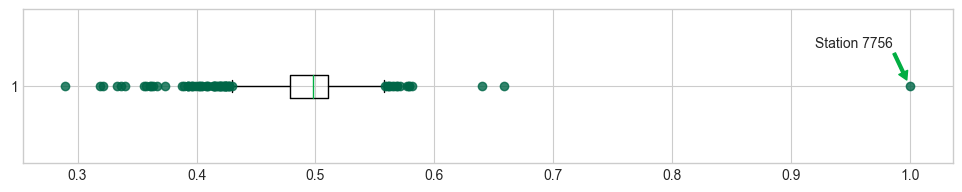

In [12]:
# Viewing the distribution of end-ratio data as a boxplot, in can be seen that the station with no "start_count" data from above (Station 7756)
# is extremely far from other data points (even from other outliers). This is because it has only "end_count" data (1 ride) and no "start_count"
# data. Since the statistic "end_ratio" is not weighted in any way by the station's use, Station 7756 would have an equal affect on a linear
# regression of "end_ratio", even though its "end_ratio" is derived from only 1 ride out of 4,230,582 rides in the data set. For this reason,
# Station 7756 will be removed from the final regression plot.
plt.figure(figsize=(12,2))
plt.boxplot(station_data['end_ratio'], vert=False,
            flierprops={'markerfacecolor': c_1_dec_alpha8,
                        'markeredgecolor': c_1_dec_alpha8},
                        medianprops={'color':c_3_hex})
plt.annotate('Station 7756', xy=(0.997,1.04), xytext=(0.92, 1.25),
            arrowprops=dict(facecolor=c_3_hex, edgecolor=c_3_hex, width=2, headwidth=7, headlength=6))
plt.show()

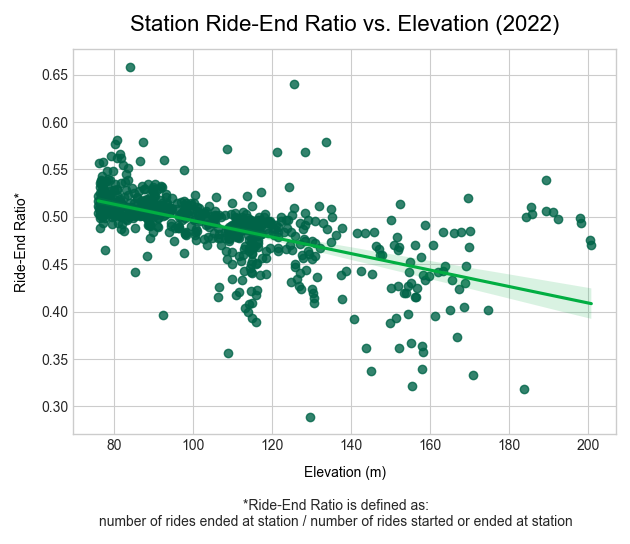

In [13]:
# Set plot style parameters
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = 'black'
plt.rcParams['axes.titlepad'] = 13
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.labelpad'] = 9
plt.rcParams['savefig.pad_inches'] = 0.15
plt.rcParams['figure.figsize'] = 7, 5

# Draw a scatterplot with regression line for only stations that were used at least twice in 2022 
sns.regplot(x="elevation", y="end_ratio", data=station_data.query('start_count + end_count >= 2'),
                 scatter_kws={"color": "#006448"}, line_kws={"color": "#01ae42"})
plt.title('Station Ride-End Ratio vs. Elevation (2022)')
plt.xlabel('Elevation (m)')
plt.ylabel('Ride-End Ratio*')
plt.figtext(0.5, -0.074, "*Ride-End Ratio is defined as:\nnumber of rides ended at station / number of rides started or ended at station",
            ha="center", fontsize=10)

plt.show()

### 5. NEXT STEPS <a class="anchor" id="5"></a>

In 2022, the average elevation loss per Bike Share Toronto ride was 1.2983 meters. The average elevation loss for an annual member ride was 0.3696 meters greater than that of a casual member ride. Stations at lower elevations tended to be ride ending locations more often than ride starting locations.

The finding from this analysis that most interests me is the tendency for stations at lower elevations to be ride ending locations more often than ride starting locations. I know that Bike Share Toronto expends resources on rebalancing its network by hiring drivers to move bikes from full stations to empty stations. I imagine that the stations that have lopsided ride starting vs ride ending usage would be the ones that place the most strain on Bike Share Toronto's rebalancing efforts. I would like to build a machine learning model that can predict what the ride-end ratio of a proposed station would be, based its longitude, latitude, and elevation. This projected ride-end ratio could then be factored into Bike Share Toronto's station placement decisions (along with other important factors, such as the station's projected usage and cost of installation).